In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

class TrajectorySimulator:
    """Simula una traiettoria 3D e genera misure IMU/GPS"""
    
    def __init__(self, duration=10.0, imu_freq=500, gps_freq=10):
        self.duration = duration
        self.imu_freq = imu_freq
        self.gps_freq = gps_freq
        self.dt_imu = 1.0 / imu_freq
        self.dt_gps = 1.0 / gps_freq
        
        # Parametri di simulazione
        self.g = 9.81  # gravità m/s^2
        
        # Caratteristiche sensori (rumore)
        self.sigma_acc = 0.05      # m/s^2
        self.sigma_gyro = 0.01     # rad/s
        self.sigma_gps_pos = 0.5   # m
        self.sigma_gps_vel = 0.1   # m/s
        
        # Bias (lenti)
        self.acc_bias = np.array([0.02, -0.01, 0.03])
        self.gyro_bias = np.array([0.001, -0.002, 0.0005])
        
        # Drift bias (random walk)
        self.sigma_acc_bias = 1e-4
        self.sigma_gyro_bias = 1e-5
        
    def generate_trajectory(self):
        """Genera traiettoria di riferimento (ground truth)"""
        t_imu = np.arange(0, self.duration, self.dt_imu)
        n_imu = len(t_imu)
        
        # Inizializza stati ground truth
        pos_gt = np.zeros((n_imu, 3))      # NED
        vel_gt = np.zeros((n_imu, 3))      # NED
        quat_gt = np.zeros((n_imu, 4))     # qw, qx, qy, qz
        acc_bias_gt = np.zeros((n_imu, 3))
        gyro_bias_gt = np.zeros((n_imu, 3))
        
        # Condizioni iniziali
        quat_gt[0] = np.array([1.0, 0.0, 0.0, 0.0])  # orientamento iniziale
        acc_bias_gt[0] = self.acc_bias
        gyro_bias_gt[0] = self.gyro_bias
        
        # 1. Movimento circolare orizzontale + oscillazione verticale
        radius = 5.0  # m
        omega = 2 * np.pi / 5.0  # periodo 5 secondi
        
        for i in range(1, n_imu):
            t = t_imu[i]
            
            # ---- TRAIETTORIA GROUND TRUTH ----
            # Posizione: cerchio orizzontale + oscillazione verticale
            pos_gt[i, 0] = radius * np.cos(omega * t)  # North
            pos_gt[i, 1] = radius * np.sin(omega * t)  # East
            pos_gt[i, 2] = -1.0 * (1 + 0.5 * np.sin(0.5 * omega * t))  # Down (-altezza)
            
            # Velocità: derivata della posizione
            vel_gt[i, 0] = -radius * omega * np.sin(omega * t)  # North vel
            vel_gt[i, 1] = radius * omega * np.cos(omega * t)   # East vel
            vel_gt[i, 2] = -0.5 * 0.5 * omega * np.cos(0.5 * omega * t)  # Down vel
            
            # Accelerazione NED (ground truth)
            acc_ned_gt = np.array([
                -radius * omega**2 * np.cos(omega * t),  # North acc
                -radius * omega**2 * np.sin(omega * t),  # East acc
                0.5 * (0.5 * omega)**2 * np.sin(0.5 * omega * t)  # Down acc
            ])
            
            # ---- ORIENTAMENTO ----
            # Rotazione lenta attorno all'asse verticale (yaw)
            yaw_rate = 0.2  # rad/s
            roll = 0.1 * np.sin(0.5 * omega * t)  # leggero rollio
            pitch = 0.05 * np.cos(omega * t)      # leggero beccheggio
            
            # Quaternione ground truth
            r = R.from_euler('ZYX', [yaw_rate * t, pitch, roll])
            quat_gt[i] = r.as_quat()  # [x, y, z, w]
            # Riorganizza in [w, x, y, z]
            quat_gt[i] = np.roll(quat_gt[i], 1)
            
            # ---- BIAS (random walk) ----
            if i > 0:
                acc_bias_gt[i] = acc_bias_gt[i-1] + np.random.normal(0, self.sigma_acc_bias * np.sqrt(self.dt_imu), 3)
                gyro_bias_gt[i] = gyro_bias_gt[i-1] + np.random.normal(0, self.sigma_gyro_bias * np.sqrt(self.dt_imu), 3)
        
        return t_imu, pos_gt, vel_gt, quat_gt, acc_bias_gt, gyro_bias_gt
    
    def generate_imu_measurements(self, pos_gt, vel_gt, quat_gt, acc_bias_gt, gyro_bias_gt):
        """Genera misure IMU dal ground truth"""
        n = len(pos_gt)
        
        # Allocate arrays
        acc_meas = np.zeros((n, 3))
        gyro_meas = np.zeros((n, 3))
        acc_true = np.zeros((n, 3))
        gyro_true = np.zeros((n, 3))
        
        # Calcola velocità angolare ground truth (approssimata)
        gyro_true[0] = np.array([0.0, 0.0, 0.2])  # yaw rate iniziale
        
        for i in range(n):
            # Matrice di rotazione body->NED
            r = R.from_quat(np.roll(quat_gt[i], -1))  # [x, y, z, w]
            R_b_to_n = r.as_matrix()
            
            # Accelerazione NED ground truth (dalla traiettoria)
            if i < n-1:
                vel_next = vel_gt[i+1] if i+1 < n else vel_gt[i]
                acc_ned = (vel_next - vel_gt[i]) / self.dt_imu
            else:
                acc_ned = np.zeros(3)
            
            # Aggiungi gravità (NED: giù positivo)
            acc_ned[2] += self.g
            
            # Accelerazione vera in body frame
            acc_true_body = R_b_to_n.T @ acc_ned
            
            # Velocità angolare vera (approssimata dalla derivata dell'orientamento)
            if i > 0 and i < n-1:
                # Differenza quaternioni
                q_prev = R.from_quat(np.roll(quat_gt[i-1], -1))
                q_next = R.from_quat(np.roll(quat_gt[i+1], -1))
                
                # Rotazione relativa
                dq = q_next * q_prev.inv()
                gyro_true[i] = dq.as_rotvec() / (2 * self.dt_imu)
            else:
                gyro_true[i] = np.array([0.0, 0.0, 0.2])  # yaw rate costante
            
            # ---- AGGIUNGI RUMORE E BIAS ----
            # Accelerometro
            acc_meas[i] = acc_true_body + acc_bias_gt[i] + np.random.normal(0, self.sigma_acc, 3)
            
            # Giroscopio
            gyro_meas[i] = gyro_true[i] + gyro_bias_gt[i] + np.random.normal(0, self.sigma_gyro, 3)
        
        return acc_meas, gyro_meas, acc_true, gyro_true
    
    def generate_gps_measurements(self, t_imu, pos_gt, vel_gt):
        """Genera misure GPS (posizione + velocità NED)"""
        # Indici GPS (meno frequenti)
        gps_indices = np.arange(0, len(t_imu), int(self.imu_freq / self.gps_freq))
        t_gps = t_imu[gps_indices]
        
        n_gps = len(t_gps)
        gps_pos = np.zeros((n_gps, 3))
        gps_vel = np.zeros((n_gps, 3))
        
        for i, idx in enumerate(gps_indices):
            # Aggiungi rumore GPS
            gps_pos[i] = pos_gt[idx] + np.random.normal(0, self.sigma_gps_pos, 3)
            gps_vel[i] = vel_gt[idx] + np.random.normal(0, self.sigma_gps_vel, 3)
        
        return t_gps, gps_pos, gps_vel, gps_indices
    
    def run_simulation(self):
        """Esegue simulazione completa"""
        print("Generating trajectory...")
        t_imu, pos_gt, vel_gt, quat_gt, acc_bias_gt, gyro_bias_gt = self.generate_trajectory()
        
        print("Generating IMU measurements...")
        acc_meas, gyro_meas, acc_true, gyro_true = self.generate_imu_measurements(
            pos_gt, vel_gt, quat_gt, acc_bias_gt, gyro_bias_gt
        )
        
        print("Generating GPS measurements...")
        t_gps, gps_pos, gps_vel, gps_indices = self.generate_gps_measurements(t_imu, pos_gt, vel_gt)
        
        # Crea DataFrame per IMU
        df_imu = pd.DataFrame({
            'timestamp': t_imu,
            'ax': acc_meas[:, 0],
            'ay': acc_meas[:, 1],
            'az': acc_meas[:, 2],
            'gx': gyro_meas[:, 0],
            'gy': gyro_meas[:, 1],
            'gz': gyro_meas[:, 2],
            'ax_true': acc_true[:, 0],
            'ay_true': acc_true[:, 1],
            'az_true': acc_true[:, 2],
            'gx_true': gyro_true[:, 0],
            'gy_true': gyro_true[:, 1],
            'gz_true': gyro_true[:, 2],
            'pos_north_true': pos_gt[:, 0],
            'pos_east_true': pos_gt[:, 1],
            'pos_down_true': pos_gt[:, 2],
            'vel_north_true': vel_gt[:, 0],
            'vel_east_true': vel_gt[:, 1],
            'vel_down_true': vel_gt[:, 2],
            'qw_true': quat_gt[:, 0],
            'qx_true': quat_gt[:, 1],
            'qy_true': quat_gt[:, 2],
            'qz_true': quat_gt[:, 3],
            'acc_bias_x_true': acc_bias_gt[:, 0],
            'acc_bias_y_true': acc_bias_gt[:, 1],
            'acc_bias_z_true': acc_bias_gt[:, 2],
            'gyro_bias_x_true': gyro_bias_gt[:, 0],
            'gyro_bias_y_true': gyro_bias_gt[:, 1],
            'gyro_bias_z_true': gyro_bias_gt[:, 2]
        })
        
        # Crea DataFrame per GPS
        df_gps = pd.DataFrame({
            'timestamp': t_gps,
            'gps_north': gps_pos[:, 0],
            'gps_east': gps_pos[:, 1],
            'gps_down': gps_pos[:, 2],
            'gps_vn': gps_vel[:, 0],
            'gps_ve': gps_vel[:, 1],
            'gps_vd': gps_vel[:, 2],
            'pos_north_true': pos_gt[gps_indices, 0],
            'pos_east_true': pos_gt[gps_indices, 1],
            'pos_down_true': pos_gt[gps_indices, 2],
            'vel_north_true': vel_gt[gps_indices, 0],
            'vel_east_true': vel_gt[gps_indices, 1],
            'vel_down_true': vel_gt[gps_indices, 2]
        })
        
        return df_imu, df_gps
    
    def save_to_csv(self, df_imu, df_gps, prefix="sim"):
        """Salva dati in CSV"""
        imu_file = f"{prefix}_imu.csv"
        gps_file = f"{prefix}_gps.csv"
        
        df_imu.to_csv(imu_file, index=False)
        df_gps.to_csv(gps_file, index=False)
        
        print(f"Saved {imu_file} with {len(df_imu)} IMU samples")
        print(f"Saved {gps_file} with {len(df_gps)} GPS samples")
        
        return imu_file, gps_file
    
    def plot_trajectory(self, df_imu, df_gps):
        """Visualizza traiettoria simulata"""
        fig = plt.figure(figsize=(15, 10))
        
        # 1. Traiettoria 3D
        ax1 = fig.add_subplot(231, projection='3d')
        ax1.plot(df_imu['pos_east_true'], df_imu['pos_north_true'], -df_imu['pos_down_true'])
        ax1.scatter(df_gps['gps_east'], df_gps['gps_north'], -df_gps['gps_down'], 
                   c='red', s=10, label='GPS measurements')
        ax1.set_xlabel('East [m]')
        ax1.set_ylabel('North [m]')
        ax1.set_zlabel('Altitude [m]')
        ax1.set_title('3D Trajectory')
        ax1.legend()
        ax1.grid(True)
        
        # 2. Posizione vs tempo
        ax2 = fig.add_subplot(232)
        ax2.plot(df_imu['timestamp'], df_imu['pos_north_true'], label='North')
        ax2.plot(df_imu['timestamp'], df_imu['pos_east_true'], label='East')
        ax2.plot(df_imu['timestamp'], -df_imu['pos_down_true'], label='Altitude')
        ax2.scatter(df_gps['timestamp'], df_gps['gps_north'], c='red', s=10, alpha=0.5)
        ax2.scatter(df_gps['timestamp'], df_gps['gps_east'], c='green', s=10, alpha=0.5)
        ax2.set_xlabel('Time [s]')
        ax2.set_ylabel('Position [m]')
        ax2.set_title('Position vs Time')
        ax2.legend()
        ax2.grid(True)
        
        # 3. Velocità vs tempo
        ax3 = fig.add_subplot(233)
        ax3.plot(df_imu['timestamp'], df_imu['vel_north_true'], label='North')
        ax3.plot(df_imu['timestamp'], df_imu['vel_east_true'], label='East')
        ax3.plot(df_imu['timestamp'], df_imu['vel_down_true'], label='Down')
        ax3.scatter(df_gps['timestamp'], df_gps['gps_vn'], c='red', s=10, alpha=0.5)
        ax3.scatter(df_gps['timestamp'], df_gps['gps_ve'], c='green', s=10, alpha=0.5)
        ax3.set_xlabel('Time [s]')
        ax3.set_ylabel('Velocity [m/s]')
        ax3.set_title('Velocity vs Time')
        ax3.legend()
        ax3.grid(True)
        
        # 4. Accelerometro
        ax4 = fig.add_subplot(234)
        ax4.plot(df_imu['timestamp'], df_imu['ax'], alpha=0.5, label='ax meas')
        ax4.plot(df_imu['timestamp'], df_imu['ay'], alpha=0.5, label='ay meas')
        ax4.plot(df_imu['timestamp'], df_imu['az'], alpha=0.5, label='az meas')
        ax4.plot(df_imu['timestamp'], df_imu['ax_true'], 'k--', alpha=0.7, label='ax true')
        ax4.plot(df_imu['timestamp'], df_imu['ay_true'], 'k--', alpha=0.7, label='ay true')
        ax4.plot(df_imu['timestamp'], df_imu['az_true'], 'k--', alpha=0.7, label='az true')
        ax4.set_xlabel('Time [s]')
        ax4.set_ylabel('Acceleration [m/s²]')
        ax4.set_title('Accelerometer')
        ax4.legend()
        ax4.grid(True)
        
        # 5. Giroscopio
        ax5 = fig.add_subplot(235)
        ax5.plot(df_imu['timestamp'], df_imu['gx'], alpha=0.5, label='gx meas')
        ax5.plot(df_imu['timestamp'], df_imu['gy'], alpha=0.5, label='gy meas')
        ax5.plot(df_imu['timestamp'], df_imu['gz'], alpha=0.5, label='gz meas')
        ax5.plot(df_imu['timestamp'], df_imu['gx_true'], 'k--', alpha=0.7, label='gx true')
        ax5.plot(df_imu['timestamp'], df_imu['gy_true'], 'k--', alpha=0.7, label='gy true')
        ax5.plot(df_imu['timestamp'], df_imu['gz_true'], 'k--', alpha=0.7, label='gz true')
        ax5.set_xlabel('Time [s]')
        ax5.set_ylabel('Angular rate [rad/s]')
        ax5.set_title('Gyroscope')
        ax5.legend()
        ax5.grid(True)
        
        # 6. Bias
        ax6 = fig.add_subplot(236)
        ax6.plot(df_imu['timestamp'], df_imu['acc_bias_x_true'], label='acc bias x')
        ax6.plot(df_imu['timestamp'], df_imu['acc_bias_y_true'], label='acc bias y')
        ax6.plot(df_imu['timestamp'], df_imu['acc_bias_z_true'], label='acc bias z')
        ax6.plot(df_imu['timestamp'], df_imu['gyro_bias_x_true'], '--', label='gyro bias x')
        ax6.plot(df_imu['timestamp'], df_imu['gyro_bias_y_true'], '--', label='gyro bias y')
        ax6.plot(df_imu['timestamp'], df_imu['gyro_bias_z_true'], '--', label='gyro bias z')
        ax6.set_xlabel('Time [s]')
        ax6.set_ylabel('Bias')
        ax6.set_title('Sensor Biases')
        ax6.legend()
        ax6.grid(True)
        
        plt.tight_layout()
        plt.show()


=== SIMULATING DATA ===
Generating trajectory...
Generating IMU measurements...
Generating GPS measurements...
Saved data/sim_imu.csv with 5000 IMU samples
Saved data/sim_gps.csv with 100 GPS samples


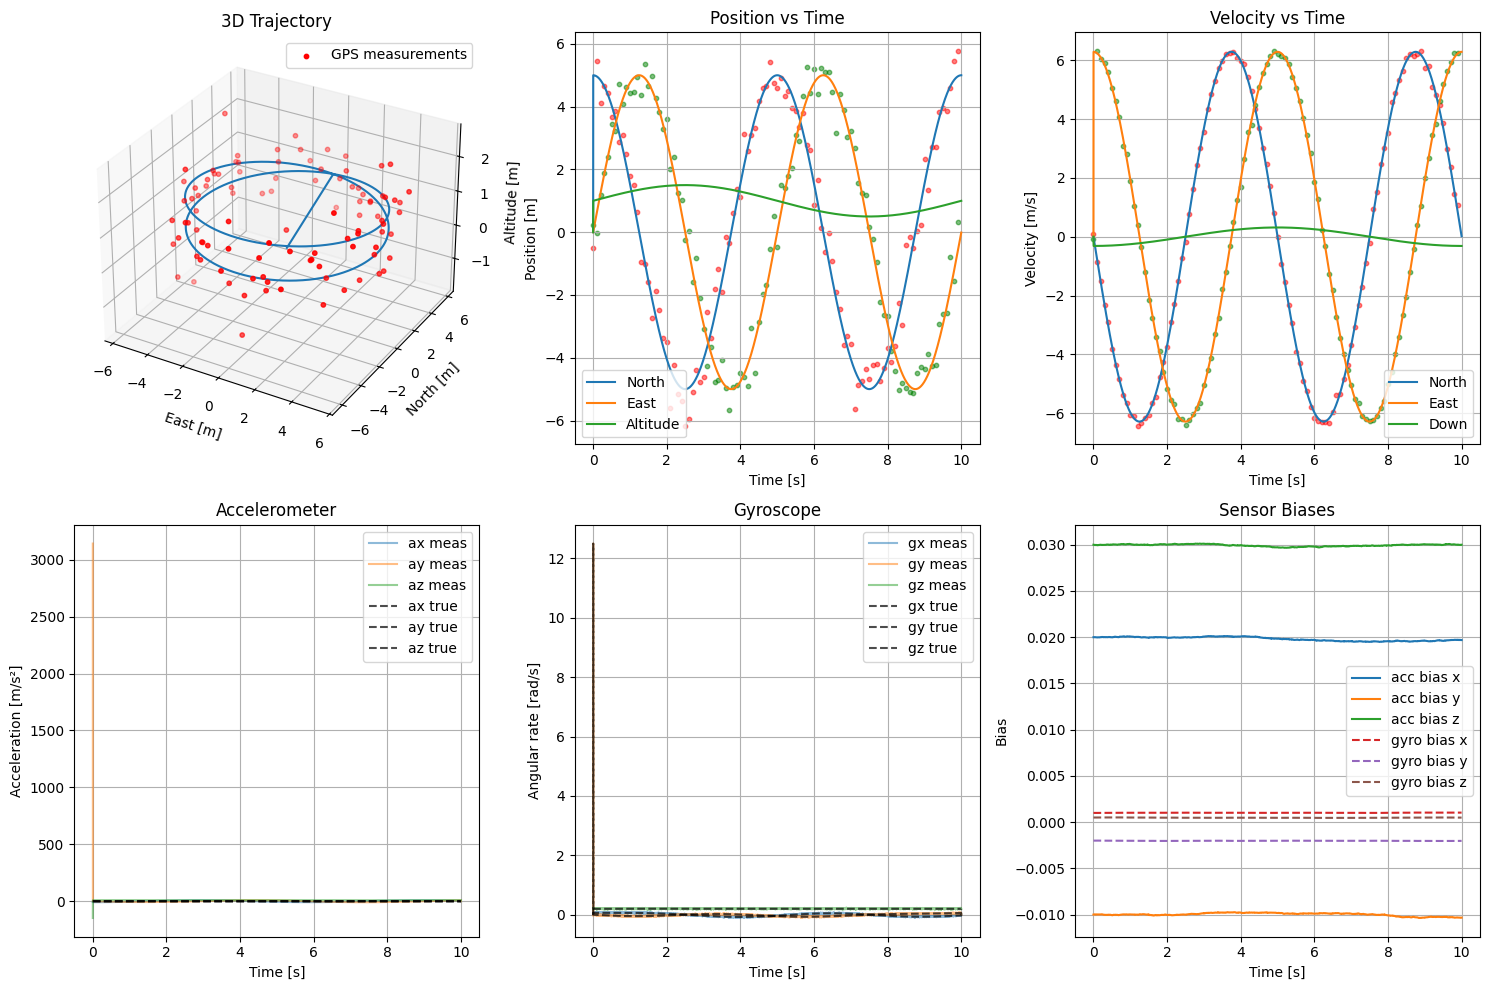

In [2]:
print("=== SIMULATING DATA ===")
simulator = TrajectorySimulator(
    duration=10.0,    # 10 secondi
    imu_freq=500,     # 500 Hz
    gps_freq=10       # 10 Hz
)
    
df_imu, df_gps = simulator.run_simulation()
simulator.save_to_csv(df_imu, df_gps, "data/sim")
    
# Visualizza dati simulati
simulator.plot_trajectory(df_imu, df_gps)